In [1]:
import pandas as pd
import requests
import json
from sodapy import Socrata
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from statsmodels.formula.api import ols
from patsy import dmatrices
import statsmodels.api as sm 

# Data 512 Final Project: 
# Discrimination In the United States: Experiences of Asian Ethnic Group in the City of Austin
### Author: Jeffrey Lai

# I. Motivation

Asian American is the fastest-growing racial group in the United States according to the research by Pew Research Center. The City of Austin in Texas is no exception. According to the data released by the government of Austin, the number of Asians in Austin is doubling every 10 years compared with the general population which doubles every 20 to 25 years. Yet, the majority of the group is still immigrants. Once here, Asian immigrant families face many obstacles, such as language barriers, culture shock, and ongoing adjustments to new lives. One of the most prevalent issues that most immigrants face is racism and discrimination. Many studies have found that racism has been linked with increased risk of health and lower satisfaction of life. The survey conducted by the City of Austin collects data from 230 different questions from the Asian immigration group to help us better understand their life experience and the basis of a personal characteristic that causes the immigration group treated unfairly in the United States.

# II. Selected Data for analysis

The data contains more than 2000 rows and 230 attributes collecting from the surveys the city government sent out in 2020. The questions accurately measure the respondents' opinions, behaviors, and experiences. The demographic data regarding age, gender, and marital status are also retrieved. Few ethical considerations will also be addressed in our research.

The dataset can be collected through API here: https://data.austintexas.gov/City-Government/Final-Report-of-the-Asian-American-Quality-of-Life/hc5t-p62z

For API documentation, please visit here: https://dev.socrata.com/foundry/data.austintexas.gov/hc5t-p62z

Terms of Service:
https://austintexas.gov/page/city-austin-open-data-terms-use

# III. Research questions

#### 1. How does discriminatory experience across age have an effect on the quality of life in the City of Austin?

#### 2. Does limited English proficiency lead to racial discrimination?

#### 3. Does the income class correlate with discriminatory experience in the City of Austin?

# IV. Related Work

One of the most prevalent issues that most immigrants face today is racism and discrimination. In the study by Yoo, Gee, and Takeuchi investigating discrimination within an Asian American community, 21% of the respondents reported being racially discriminated against because of their race, language, and accent. The other study researched by the same group of researchers indicates that racial discrimination has been recognized as the key determinant of mental disorders and depressive symptoms. The project will examine several personal characteristics, including income level, marital status, and age to identify different factors behind the discrimination in the Asian immigration group in the City of Austin, Texas. The outcome of the analysis will help the city improve race relations and ensure equal treatment to its people.

# V. Methodology

The methodology for this project focuses on the mix of descriptive and regression analysis to understand the basis of a personal characteristic that causes racial discrimination among Asian immigrant families.
The survey data is a two-dimensional data structure with organized rows and columns that is well-suited for both methods. Each entry of which represents a participant's answer to the survey questions, making it efficient to manipulate and perform analysis at different levels. We will begin with a descriptive analysis to identify outliers and detect typos in the survey data. Then, we will use the same method to summarize the characteristics of the data in a meaningful way. For example, we will calculate the average number of discrimination per person across different age groups as well as including the average quality of life in the analysis. We will also refine our calculation to compute the percentage of racial discrimination experienced across gender and marital status. Lastly, we will introduce the linear regression model to the project. Linear regression is a powerful way of discovering the relationship between one or more predictor variables and the response. The method provides important evaluation metrics such as regression coefficients and p-values. We will be interpreting the outputs carefully to understand what factors are significant predictors of the outcome variable. (i.e., the quality of life and the percentage of racial discrimination among the Asian immigration group)

# VI. Analysis

### There are 2 ways to retrieve data of the Asian American Quality of Life (AAQoL) provided by the City of Austin

#### 1. Communicate with API through HTTPS

In [2]:
client = Socrata("data.austintexas.gov", None)

results = client.get("hc5t-p62z", limit=3000)

# Convert to pandas DataFrame
df_api = pd.DataFrame.from_records(results)

#### 2. (Recommended) Directly read files from the Github

In [3]:
url = 'https://raw.githubusercontent.com/jeffrey25706660/data-512-final/main/Final_Report_of_the_Asian_American_Quality_of_Life__AAQoL_.csv'
df = pd.read_csv(url, error_bad_lines=False)

### Clean the data

#### Select columns required for analysis, 'Age','Gender', 'Ethnicity', 'Marital Status','Education Completed', 'Household Size', 'English Speaking', 'Income', 'Quality of Life' and drop rows with  null values.

In [4]:
result_df =  df[['Age','Gender', 'Ethnicity', 'Marital Status',
       'Education Completed', 'Household Size', 'English Speaking', 
    'Income', 'Quality of Life','Discrimination ' 
   ]].dropna(axis=0,how='all')

#### Check null values for each column. We see that there is some missing information in each attribute, which contributes between .03% to 12%.

In [5]:
result_df.isna().sum()/result_df.shape[0]

Age                    0.002685
Gender                 0.009590
Ethnicity              0.000000
Marital Status         0.006137
Education Completed    0.013425
Household Size         0.005754
English Speaking       0.006137
Income                 0.077100
Quality of Life        0.016110
Discrimination         0.120829
dtype: float64

## Research Question 1:  
### How does discriminatory experience across age have an effect on the quality of life in the City of Austin?

#### Let's begin by calculating the summary statistics on age. The survey data indicates that the age ranges from 18 - 98, showing there is no unusual data in the age column.

In [6]:
result_df['Age'].describe()

count    2600.000000
mean       42.851923
std        17.105246
min        18.000000
25%        29.000000
50%        40.000000
75%        55.000000
max        98.000000
Name: Age, dtype: float64

#### Calculate average the discrimination and quality of life against age and visualize the result

In [7]:
result_discrim = result_df.groupby(['Age']).agg({'Discrimination ': 'mean','Quality of Life': 'mean'}).reset_index()

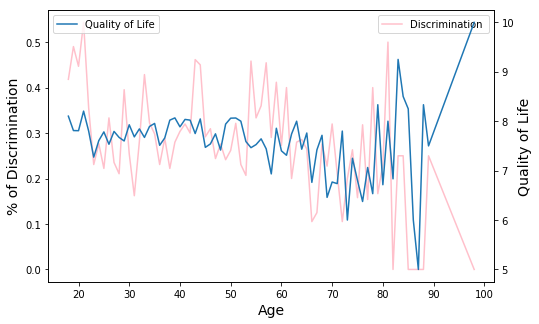

In [8]:

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(8,5))
# make a plot
ax.plot(result_discrim["Age"],result_discrim["Discrimination "], color="pink")
# set x-axis label
ax.set_xlabel("Age",fontsize=14)
# set y-axis label
ax.set_ylabel("% of Discrimination",fontsize=14)
plt.legend()
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(result_discrim["Age"],result_discrim["Quality of Life"])
ax2.set_ylabel("Quality of Life",fontsize=14)
plt.legend()
plt.show()

#### Let's categorize age into different groups to observe if there is any pattern across age groups. The bin size of each age group is 10.

In [9]:
bins= [18,28,38,48,58,68,78,88,98]
labels = ['18-28','29-38','39-48','49-58','59-68','69-78','79-88','89-98']
result_df['age goup(10)'] = pd.cut(result_df['Age'], bins=bins, labels=labels, right=True)

In [10]:
result_discrim_gp = result_df.groupby(['age goup(10)']).agg({'Discrimination ': 'mean','Quality of Life': 'mean'}).reset_index()

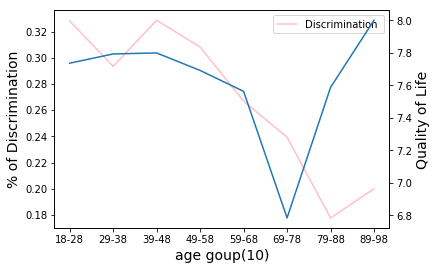

<Figure size 432x288 with 0 Axes>

In [11]:
fig,ax = plt.subplots()
# make a plot
ax.plot(result_discrim_gp.index,result_discrim_gp["Discrimination "], color="pink")
# set x-axis label
ax.set_xlabel("age goup(10)",fontsize=14)
# set y-axis label
ax.set_ylabel("% of Discrimination",fontsize=14)
plt.legend()
positions = (0, 1, 2, 3, 4, 5, 6, 7)

plt.xticks(positions, labels)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(result_discrim_gp.index,result_discrim_gp["Quality of Life"])
ax2.set_ylabel("Quality of Life",fontsize=14)
#plt.legend()
plt.show()
plt.savefig('age_group_vs_discrimination.png')

#### We can further understand the relationship between discrimination and quality of life. By simply plotting the scatter plot, the relationship between 2 variables seems to be weak. We will perform a linear regression to validate our assumption

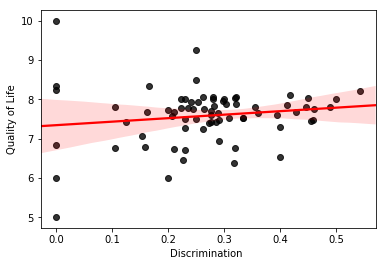

In [12]:
sns.regplot(x='Discrimination ',y='Quality of Life',data=result_discrim, scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.savefig("regression analysis")

### Model Interpretation: 
The two-sided p-value for a hypothesis test whose null hypothesis states the slope is .1856. The result shows that it fails to reject the null hypothesis, showing that there is no relationship between discriminatory experience and the response variable, quality of life in the City of Texas.

In [13]:
slope, intercept, r_value, p_value, std_err = stats.linregress(result_discrim['Discrimination '],result_discrim['Quality of Life'])

In [14]:
print('Standard error:', std_err)

Standard error: 0.6647812852313506


In [15]:
print('P-value:', p_value)

P-value: 0.1856273301670736


In [16]:
print('Slope:', slope)

Slope: 0.8885331272726916


In [17]:
print('R-value:', r_value)

R-value: 0.1566641349449716


### Discussion/Implications:

Prior to conducting the research, we assume a higher percentage of discriminatory experience will lead to a lower quality of life in the City of Austin. The result from the regression analysis indicates that there is no significant relationship between two variables across age. The descriptive analysis of visualizing discriminatory experience against the quality of life by age and age groups shows that both variables fluctuate in the same direction, meaning that even though the respondents did experience racial discrimination in the City of Austin, the concern may not have a significant impact on the quality of life. The reasons can be that the government and non-profit organizations in the state offer accessible personal and professional resources for anti-racism work on government websites. For example, the Texas Workforce Commission offers channels to file complaints to protect against employment discrimination based on color and TexasLawHelp provides free legal information and court forms for civil legal problems.


### Limitations:

The bias in the sampling data may raise the concern. After running multiple descriptive analyses, we observe that there exists an imbalance in one of the attributes. The images below suggest that the survey data is dominated by married participants, which comprises 67% of the data collection. This phenomenon will predetermined ideas or influences in certain direction. For example, the percentage of discriminatory experience by married respondents is much lower than an unmarried person. If we were to train a model to predict the ratio of discriminatory experience in the City of Austin, the model's outcome will be skewed toward marrieds. The researcher must ensure that collected data can reflect the demographics in society in future research.

In [18]:
result_gen_df = result_df[ result_df['Marital Status'] != 'Other'].groupby(['Marital Status']).agg({'Discrimination ': 'mean','Quality of Life': 'count'}).sort_values(by='Quality of Life', ascending=False).rename(columns={'Quality of Life': 'Records'})

#### Percentage of respondents by marital status

In [19]:
result_df_marital = result_df[ result_df['Marital Status'] != 'Other'].groupby(['Marital Status']).agg({'Discrimination ': 'mean','Quality of Life': 'count'}).sort_values(by='Quality of Life', ascending=False).rename(columns={'Quality of Life': 'Records'})

result_df_marital['% of Records'] = result_df_marital['Records']/result_df_marital['Records'].sum()

result_df_marital

,Discrimination,Records,% of Records
Marital Status,,,
Married,0.282438,1704,0.675386
Single,0.358044,717,0.284185
Living with a partner,0.287234,102,0.040428


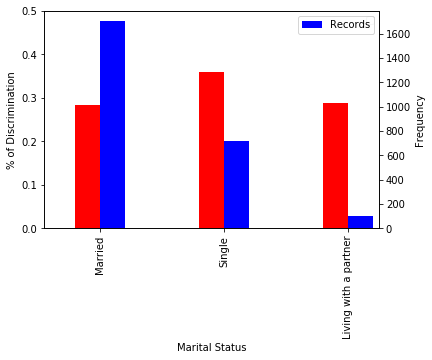

In [20]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
ax.set_ylim((0,.5))
ax.legend()
width = 0.2
result_gen_df['Records'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
result_gen_df['Discrimination '].plot(kind='bar', color='red', ax=ax, width=width, position=1)


ax.set_ylabel('% of Discrimination')
ax2.set_ylabel('Frequency')
ax2.legend()
plt.show()

## Research Question 2
#### Does limited English proficiency lead to racial discrimination?

#### Let's first look at the overall discriminatory experience by English proficiency. Interesting enough, 35% of the respondents who are fluent in English report prior experience with racial discrimination.

In [21]:
ability_df = result_df[result_df['English Speaking'].notnull()].groupby(['English Speaking']).agg({'Discrimination ':'mean'}).sort_values(by=['Discrimination '],ascending=False).reset_index()

In [22]:
ability_df

,English Speaking,Discrimination
0,Very well,0.357309
1,Not well,0.296099
2,Well,0.277539
3,Not at all,0.145570


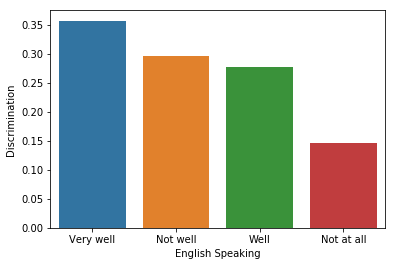

In [23]:
gx = sns.barplot(x='English Speaking' ,y = 'Discrimination ',data=ability_df)
plt.savefig("English_Speaking_vs_Discrimination.png")

#### Let's break down the graph by ethnicity. The result suggests that regardless of the participant's ethnicity, strong English speaking ability does show the highest ratio of discriminatory experience.

In [24]:
ability_eth_df = result_df[(result_df['English Speaking'].notnull()) & (result_df['Ethnicity'] != 'Other') ].groupby(['Ethnicity','English Speaking']).agg({'Discrimination ':'mean'}).sort_values(by=['Ethnicity','Discrimination '],ascending=False).reset_index()

In [25]:
ability_eth_df

,Ethnicity,English Speaking,Discrimination
0,Vietnamese,Very well,0.427419
1,Vietnamese,Well,0.347222
2,Vietnamese,Not well,0.240260
3,Vietnamese,Not at all,0.192308
4,Korean,Very well,0.482353
5,Korean,Not well,0.346369
6,Korean,Well,0.335821
7,Korean,Not at all,0.217391
8,Filipino,Very well,0.355705
9,Filipino,Well,0.181818


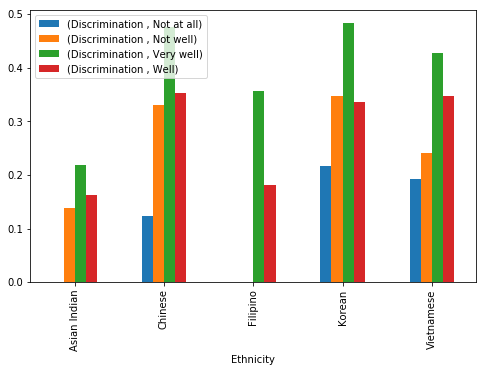

In [26]:
ability_eth_df.set_index([ 'Ethnicity','English Speaking']).unstack().plot(kind='bar',figsize=(8,5))
plt.legend(loc='upper left')
plt.show()

### Discussion/Implications:
The analysis shows that fluent English speakers and limited English speakers are two groups that have a high percentage of experiencing racial inequality in the City of Austin, which indicates that regardless of English speaking ability, a person from the Asian immigration group may have been discriminated against in any way. One implication appears to be that individuals are treated differently based on their physical appearance and traits. The other implication can be of linguistic bias. Asian ethnic group comprises different origin groups and cultures. Each of the origins has a unique use of language and characteristics of speech, which is profoundly different from western culture. Because of the existing discrepancy, it will implicitly lead to unfair treatment of immigrant Asian Americans due to their first language, accent, and size of the vocabulary.


### Limitations:
The data is sourced from several countries of origin, comprising of Chinese, Asian Indian, Vietnamese, Korean, and Filipino ethnic groups. However, the collected survey data does not reflect the demographic trends provided by the Commission on Immigrant Affairs of Austin. According to the data, the Chinese stand about 12% and the Indian made up 18% of the Asian ethnic group.

The survey data overrepresents these two groups as they are contributing 24% and 22% respectively. Moreover, Chinese and Asian Indian ethnic groups represent two peaks of the discriminatory experience in the data, where one reports the highest percentage of discrimination and the other show the lowest percentage in the city. The unintentional biases in the data will not accurately represent the discriminatory experience against other underrepresented groups.

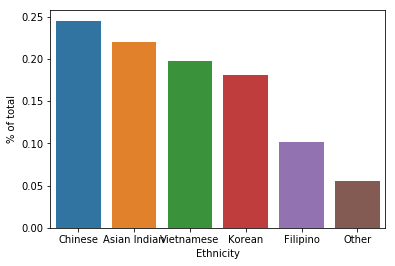

In [27]:
ex = sns.barplot(x= 'Ethnicity', y ='% of total', data=(result_df.groupby(['Ethnicity']).size().sort_values(ascending=False)/result_df.shape[0]).reset_index().rename(columns={0:'% of total'}))


## Research Question 3:
#### Does the income class correlate with discriminatory experience in the City of Austin?

#### Let's first remove any unreported income from the data.

In [28]:
result_ic_temp = result_df[(result_df['Income'].notnull()) & (result_df['Discrimination '].notnull())].rename(columns={'Discrimination ': 'Discrimination'})

#### Then, let's aggregate the percentage of discriminatory experience by income level 

In [29]:
result_ic_df = result_ic_temp[['Income','Discrimination']].groupby(['Income']).agg({'Discrimination': 'mean'}).reset_index().rename(columns={'Discrimination': '% of Discrimination'})

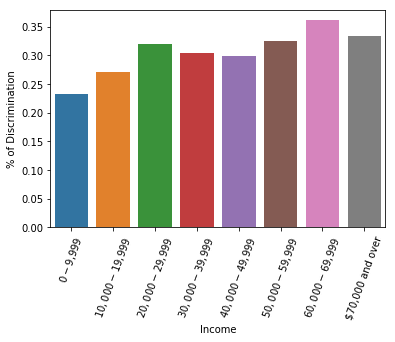

In [30]:
icx = sns.barplot(x= 'Income', y ='% of Discrimination', data=result_ic_df)
plt.xticks(rotation=70)
plt.savefig("Income_Level_vs_Discrimination.png")

#### To further validate our observation, we perform a regression analysis on the categorical variable, income level.

In [31]:
result_ic_cat = result_ic_temp[['Income','Discrimination']].sort_values(by='Discrimination',ascending=True)

#### Encode categorical variables and run logistic regression. The result of the logit regression shows that P-value is less than .05. We reject the null hypothesis, meaning that the coefficient is significant. The coefficient indicates as we move away from the baseline, which is the income group of 0 to 9,999 dollars, we will expect the odds of discriminatory experience to increase by about 6%.

In [32]:
result_ic_cat['Income_cat'] = result_ic_cat['Income'].astype('category').cat.codes

In [33]:
y, X = dmatrices('Discrimination ~ Income_cat', result_ic_cat, return_type = 'dataframe')

In [34]:
logit = sm.Logit(y, X)
logit.fit().params

Optimization terminated successfully.
         Current function value: 0.618831
         Iterations 5


C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


Intercept    -1.047177
Income_cat    0.055805
dtype: float64

In [35]:
logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.618831
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         Discrimination   No. Observations:                 2119
Model:                          Logit   Df Residuals:                     2119
Method:                           MLE   Df Model:                           -1
Date:                Sun, 13 Dec 2020   Pseudo R-squ.:                0.003519
Time:                        14:19:42   Log-Likelihood:                -1311.3
converged:                       True   LL-Null:                       -1315.9
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0472      0.099    -10.606      0.000      -1.241      -0.854
Income_cat     0.0558      0.018      3.021      0.003       0.020       0.092
==============================================================================
"""

In [36]:
print('The odd ratio as we move away from the baseline group: ', np.exp(0.0558)-1)

The odd ratio as we move away from the baseline group:  0.057386185350407626


### Discussion/Implications:
Before the research, we expect the income class may have a negative relationship with discriminatory experience in the Asian ethnic group. The result, however, disproves our assumption. The descriptive analysis and the statistical inference for logistic regression suggest that the income class has a positive relationship with the prior experience of racial discrimination, meaning that as the income level increases, we will expect the discriminatory experience raises as well. The phenomenon indicates that even the middle class of immigrant Asian Americans still have to handle numerous personal experiences of unfair treatment across many areas of life and workspace such as ethnic slurs and offensive comments, pay or compensation inequality, promotion discrimination, and unjustified firings. 

### Limitations:
The survey data shows a negatively-skewed distribution of participants' income levels. We can observe more than 40% of the respondents earn more than 70,000 in income in the City of Austin compared with 8% from the rest of the groups. The overrepresentation of the specific income level creates repercussions. The insidious outcome includes inaccurately measuring the overall quality of life experience of the residents as well as performing unreliable predictions of various metrics for lower-income students and lower-class families since the bias data causes the analysis to lose its objectivity in the first place. The survey researchers must reconsider data sampling techniques, in which income groups are over or underrepresented in the survey data.


In [37]:
result_ic_agg_df = result_ic_temp[['Income','Discrimination']].groupby(['Income']).agg({'Discrimination': 'count'}).reset_index().rename(columns={'Discrimination': 'records'})

In [38]:
result_ic_agg_df['% of Records'] = result_ic_agg_df['records']/result_ic_agg_df['records'].sum()
result_ic_agg_df

,Income,records,% of Records
0,"$0 - $9,999",228,0.107598
1,"$10,000 - $19,999",177,0.083530
2,"$20,000 - $29,999",166,0.078339
3,"$30,000 - $39,999",178,0.084002
4,"$40,000 - $49,999",164,0.077395
5,"$50,000 - $59,999",163,0.076923
6,"$60,000 - $69,999",158,0.074563
7,"$70,000 and over",885,0.417650


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

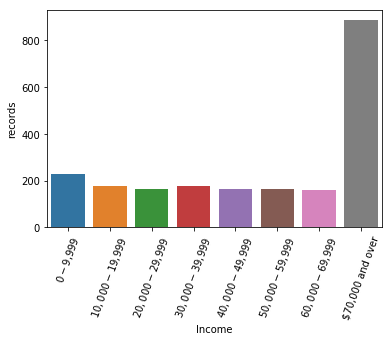

In [39]:
icx = sns.barplot(x= 'Income', y ='records', data=result_ic_agg_df)
plt.xticks(rotation=70)

### Conclusion 

As being the fastest-growing racial group in the United States, immigrant Asian Americans still face racism across many areas of life. The research analyzes the survey data conducted by the City of Austin, which collects data from 2600 participants to understand the impact of racism on their life experience in the United States and the basis of a personal characteristic that possibly causes the group treated unfairly. We formulated three research questions in the project and performed a mix of descriptive and regression analysis to summarize the characteristics of the data and understand the relationship between predictor variables and the response.

The key finding from our first research question suggests that the respondent's prior experience in racial discrimination does not have a statistically significant relationship with quality of life in the City of Texas. The result implies that the state governments and non-profit organizations offer accessible personal and professional resources, enabling victims of racism to seek free legal information and court forms for civil legal problems immediately. Despite government efforts to ensure equal treatment in society, racism still takes place against the Asian ethnic group. In our second and third research questions, we dive deeper into demographic data regarding age, gender, and marital status to recognize the key characteristics resulting in unfair treatment.

The results from other research questions show that regardless of English speaking ability, a high percentage of individuals from the Asian immigration group still report being discriminated against in any way, implying that they are treated differently based on their physical appearance and linguistic bias because of the unique use of language and characteristics of speech. The middle-class immigrant Asian Americans do not experience less racism. The outcome of the logistic regression indicates that the odds ratio of discriminatory experience tends to increase by 6% for every 1000 increase in income, suggesting that unfair treatment still across many areas of workspace such as compensation inequality, promotion discrimination, and unjustified firings.

Few limitations were identified throughout the exploratory analysis. The sampling technique raises the concern about bias in the data. For instance, the survey data is dominated by married participants whose percentage of discriminatory experience is much lower than an unmarried person. The overrepresentation of Chinese and Asian Indian ethnic groups will result in inaccurately represent the discriminatory experience against underrepresented groups. Furthermore, the survey collects more than 40% of responses from the respondents earning more than 70,000 in income in the City of Austin, imposing consequences for performing unreliable predictions of various metrics for lower-income students and lower-class families. The survey researchers must reexamine their data-collection process, overcoming biases in underrepresented groups.

 


# References:

[1]Gee GC, Spencer M, Chen J, Yip T, Takeuchi DT. The association between self-reported discrimination and 12-month DSM-IV mental disorders among Asian Americans nationwide. Social Science & Medicine. 2007b;64:1984–1996. Retrieved from https://www.researchgate.net/publication/227914163_Strangers_Still_The_Experience_of_Discrimination_Among_Chinese_Americans

[2]Yoo HC, Lee RM. Ethnic identity and approach-type coping as moderators of the racial discrimination/well-being relation in Asian Americans. Journal of Counseling Psychology. 2005;52:497–506. Retrieved from https://psycnet.apa.org/record/2005-13343-006

[3] The City of Austin. Top Ten Demographic Trends in Austin, Texas. Retrieved from https://www.austintexas.gov/page/top-ten-demographic-trends-austin-texas; https://www.austintexas.gov/sites/default/files/files/Planning/asians_by_origin.pdf

[4] Pew Research Centery. Key facts about Asian Americans, a diverse and growing population. Retrieved from https://www.pewresearch.org/fact-tank/2020/05/07/asian-americans-are-the-fastest-growing-racial-or-ethnic-group-in-the-u-s-electorate/